# Homework 2

Compute Homographies Between Images

Note 0: Feel free to use a cursor to hand pick the corners in the image
- Feel free to use the matplotlib.pyplot.ginput function

Note 1: Pixel values may not fall on exact integer values. You can use the following call (or something
like it to warp the image).
- #Warp source image to destination based on homography
- im_out = cv2.warpPerspective(im_src, h,(im_dst.shape[1],im_dst.shape[0]))

Note 2: Of course we can do the homography calculation very easily in openCV as well with the
following call (below) but in this homework we want to peek under the hood and figure it out for
ourselves.
- #Calculate Homography
- h, status = cv2.findHomography(pts_src, pts_dst)

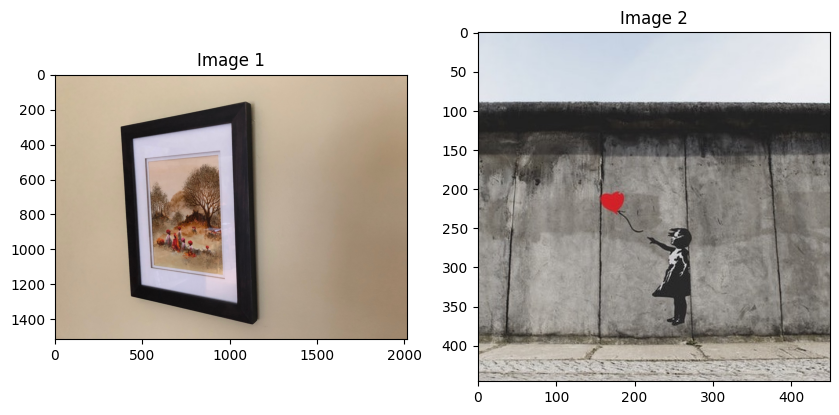

In [37]:

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Images/image2.jpg"), cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2,figsize=(10,10))

%matplotlib inline
ax[0].imshow(img1)
ax[0].title.set_text("Image 1")
ax[1].imshow(img2)
ax[1].title.set_text("Image 2")

## Problem 1
Image1 shows a picture on a wall. Our goal is to replace that picture with Image2.
In order to do this we will compute the H matrix that defines the transformation between the two
images and then map image2 in place on image1. 

Several things to consider. You can use the four corner points in each image to setup up the
computation of the H matrix and then map every pixel as needed.

In [38]:
def click_get_pixel_coords(image, num_inputs):
    # open in GUI to select points - pip install PyQt5
    %matplotlib qt
    plt.imshow(image)
    pts_selected = plt.ginput(num_inputs)
    pts_selected = np.array(pts_selected).astype(int) # convert to integer pixel
    plt.scatter(pts_selected[:,0],pts_selected[:,1], c='r') # draw point on image
    
    # revert to inline
    %matplotlib inline 
    plt.show()
    return pts_selected

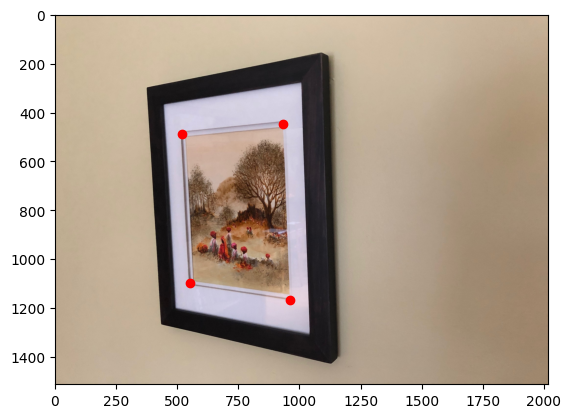

Image 1 Corner Pixel Coordinates Selected: 
 [[ 520  487]
 [ 933  447]
 [ 962 1167]
 [ 553 1097]]
Image 2 Corner Pixel Coordinates: 
 [[  0   0]
 [450   0]
 [450 446]
 [  0 446]]


In [39]:
img1_corners = click_get_pixel_coords(img1, 4)
print("Image 1 Corner Pixel Coordinates Selected: \n", img1_corners)

img2_corners = np.array([[0,0],
                         [img2.shape[1], 0],
                         [img2.shape[1], img2.shape[0]],
                         [0, img2.shape[0]]])
print("Image 2 Corner Pixel Coordinates: \n", img2_corners)

### Direct Linear Transform (DLT) Algorithm - Multiview Geometry ch 4.1
For each set of points a system of equations can be produced, where $x'$ is the source point and $x$ is the destination point in homogeneous coordinates.<br>
$ x' = Hx$<br>

$ x = [x\ y\ 1]^T$ &emsp;  $ x' = [x'\ y'\ 1]^T$<br><br>
With a cross-product, it can be rewritten in the form $ Ah = 0 $<br>
$ h = [h_1\ h_2\ h_3\ h_4\ h_5\ h_6\ h_7\ h_8\ h_9]^T$ &emsp; $ H = \begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$

By imposing the condition $h_9=1$, the set of equations was turned into an inhomogeneous set of linear equations:

$ A = \begin{bmatrix} 0 & 0 & 0 & -x & -y & -1 & xy' & yy' & y' \\ x & y & 1 & 0 & 0 & 0 & -xx' & -yx' & -x'  \end{bmatrix}$



In [40]:
# Homography Function
def get_homography(src_pts, dst_pts):
    # Create array of A matrices for each point
    A = np.zeros((len(dst_pts)*2,9))
    for i in range(len(dst_pts)):
        A[2*i] = [0.0, 0.0, 0.0, -src_pts[i,0], -src_pts[i,1], -1.0,
                   src_pts[i,0]*dst_pts[i,1], src_pts[i,1]*dst_pts[i,1], dst_pts[i,1]]
        A[2*i+1] = [src_pts[i,0], src_pts[i,1], 1.0, 0.0, 0.0, 0.0,
                   -src_pts[i,0]*dst_pts[i,0], -src_pts[i,1]*dst_pts[i,0], -dst_pts[i,0]]
        
    # Singular Value Decomposition
    U,S,Vt = np.linalg.svd(A)
    # https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog/1289595#1289595
    # select the last singular vector of V as the solution to H
    h = Vt.T[:,-1].reshape(3,3)
    h = h / h[2,2] # normalize to set bottom right val to 1.0
    return h

In [46]:
h = get_homography(img2_corners, img1_corners)
print("H Matrix: \n", h)

# Verify we get the correct H Matrix using OpenCV's Find Homography Function
h, status = cv2.findHomography(img2_corners, img1_corners)
print("\nOpenCV H Matrix Solution Check:\n", h)

H Matrix: 
 [[ 5.96834711e-01  9.97262190e-02  5.20000000e+02]
 [-2.42652609e-01  1.41876454e+00  4.87000000e+02]
 [-3.43990426e-04  4.65374098e-05  1.00000000e+00]]

OpenCV H Matrix Solution Check:
 [[ 5.96834711e-01  9.97262190e-02  5.20000000e+02]
 [-2.42652609e-01  1.41876454e+00  4.87000000e+02]
 [-3.43990426e-04  4.65374097e-05  1.00000000e+00]]


Use OpenCV's Warp Image function to apply the homograpy transformation matrix to the images

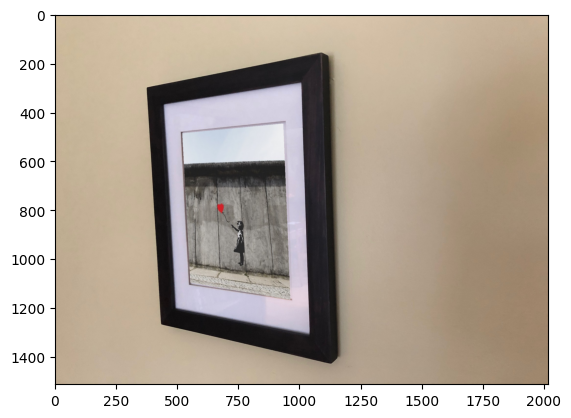

In [42]:
# https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
cv2.warpPerspective(src=img2, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)

## Problem 2
Given what we learned about homographies and how they warp images can you pick four additional
points from the two images. How would you modify the computation of the H matrix when you have
an over constrained problem (8 points as opposed to 4). 

Recompute H with these 8 points and comment on the differences in the H matrix. 

Map another image on image1 with this new homography.

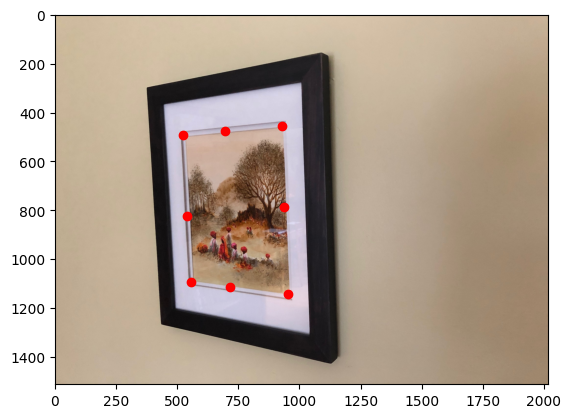

Image 1 Corner Pixel Coordinates Selected: 
 [[ 524  492]
 [ 696  475]
 [ 929  455]
 [ 937  786]
 [ 954 1142]
 [ 717 1113]
 [ 557 1093]
 [ 541  823]]
Image 2 Corner Pixel Coordinates: 
 [[  0.   0.]
 [225.   0.]
 [450.   0.]
 [450. 223.]
 [450. 446.]
 [225. 446.]
 [  0. 446.]
 [  0. 223.]]


In [55]:
img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB) # Re-import

# Select 8 points around the image border clockwise from top-left
img1_corners = click_get_pixel_coords(img1, 8)
print("Image 1 Corner Pixel Coordinates Selected: \n", img1_corners)

img2_corners = np.array([[0,0],
                         [img2.shape[1]/2, 0],
                         [img2.shape[1], 0],
                         [img2.shape[1], img2.shape[0]/2],
                         [img2.shape[1], img2.shape[0]],
                         [img2.shape[1]/2, img2.shape[0]],
                         [0, img2.shape[0]],
                         [0, img2.shape[0]/2]])
print("Image 2 Corner Pixel Coordinates: \n", img2_corners)

In [56]:
h = get_homography(img2_corners, img1_corners)
print("H Matrix: \n", h)

# Verify we get the correct H Matrix using OpenCV's Find Homography Function
h, status = cv2.findHomography(img2_corners, img1_corners)
print("\nOpenCV H Matrix Solution Check:\n", h)

H Matrix: 
 [[ 5.77002153e-01  1.09206411e-01  5.21720703e+02]
 [-2.92514586e-01  1.40481928e+00  5.05622622e+02]
 [-3.44833139e-04  7.42542849e-05  1.00000000e+00]]

OpenCV H Matrix Solution Check:
 [[ 5.93929083e-01  1.08926405e-01  5.20309924e+02]
 [-2.79345590e-01  1.40640670e+00  5.04225003e+02]
 [-3.30381937e-04  7.20322252e-05  1.00000000e+00]]


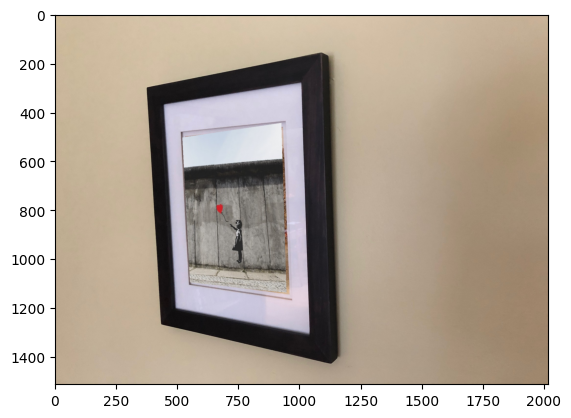

In [57]:
# https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
cv2.warpPerspective(src=img2, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)

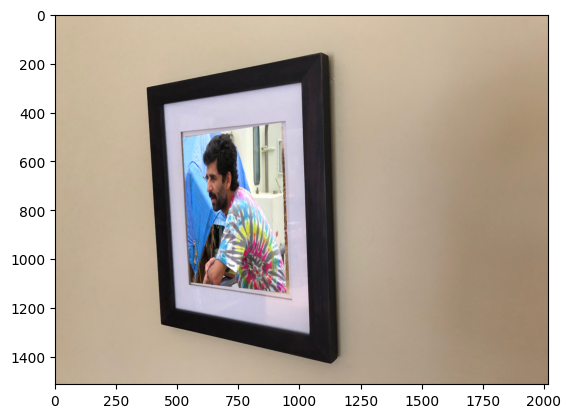

In [60]:
img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB) # reimport
img3 = cv2.cvtColor(cv2.imread("Images/hanu.jpg"), cv2.COLOR_BGR2RGB)
img3_corners = np.array([[0,0],
                         [img3.shape[1]/2, 0],
                         [img3.shape[1], 0],
                         [img3.shape[1], img3.shape[0]/2],
                         [img3.shape[1], img3.shape[0]],
                         [img3.shape[1]/2, img3.shape[0]],
                         [0, img3.shape[0]],
                         [0, img3.shape[0]/2]])

h = get_homography(img3_corners, img1_corners)

cv2.warpPerspective(src=img3, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)

For an over-determined solution, as discussed extensively in **Multiview Geometry Ch 4.1.1**, an exact solution for h is only possible if the position of the points is exact. Because of user inputs, precise point selection is not expected, causing noise. This leads to the need to find an approximate solution that minimizes a suitable cost function. SVD also works in this case, where the solution is the unit singular vector corresponding to the smallest singular value of A.

# Problem 3
Can you now take multiple images (five?) and stitch them together into a mosaic? 
- Try and stand in a spot and rotate the camera to take multiple overlapping images and then
compute the homographies and map the images onto each other while blending them.
- Please do this for a scene where have a certain distance between yourself and the scene.
- Doing it indoors is going to make it really hard on you. Please do it outside!
- Again we are hand picking four points (or more) common across each image.
- Think about how you would pick the points – collinearity, spacing etc.
- To do a simple blend you can follow the instructions here.
    - https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html
- On the topic of blending check out the classic paper by Burt and Adelson (attached)
And the real imagery that goes with it
    - http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf

In your python notebook write a 4-5 line explanation of how this method differs from the
link above.

Also here is a hint for your panorama: Use the center image as image 0 and map the
homographies from the center outwards. 